In [1]:
#import cPickle (python2.7)
#http://testpy.hatenablog.com/entry/2017/03/17/000626
import _pickle as cPickle

import numpy as np
from collections import defaultdict, OrderedDict

import re
import warnings
import sys
import time
warnings.filterwarnings("ignore") 

In [2]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.cuda.is_available()

True

In [4]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# Hyper parameters
num_epochs = 25
num_classes = 2
batch_size = 50
learning_rate = 0.001

### Load pickle data

In [6]:
# the pickle file contains [revs, W, W2, word_idx_map, vocab]
x = cPickle.load(open("mr.p","rb"), encoding="latin1") # Add encoding="latin1" because got UnicodeDecodeError

In [7]:
revs, W, W2, word_idx_map, vocab = x[0], x[1], x[2], x[3], x[4]

In [8]:
max_l = np.max(pd.DataFrame(revs)["num_words"])
print("max sentence length: ", max_l)

max sentence length:  56


In [9]:
print('revs',len(x[0])) # number of sentence
print('W', len(x[1]))
print('W2', len(x[2])) # W2 are randomly initialized vectors
print('word_idx_map', len(x[3]))
print('vocab', len(x[4]))

revs 10662
W 18766
W2 18766
word_idx_map 18765
vocab 18765


In [10]:
revs[2]

{'y': 1, 'text': 'effective but too tepid biopic', 'split': 7, 'num_words': 5}

In [11]:
word_idx_map['good'] # word and its index

12002

In [12]:
vocab['good'] # word and its count

393.0

In [13]:
# mode= sys.argv[1]
# word_vectors = sys.argv[2]

mode = "-nonstatic"
word_vectors = "-word2vec"

if mode=="-nonstatic":
    print("model architecture: CNN-non-static")
    non_static=True
elif mode=="-static":
    print("model architecture: CNN-static")
    non_static=False

#execfile("conv_net_classes.py")  

if word_vectors=="-rand":
    print("using: random vectors")
    U = W2
elif word_vectors=="-word2vec":
    print("using: word2vec vectors")
    U = W

model architecture: CNN-non-static
using: word2vec vectors


In [14]:
U.shape

(18766, 300)

### Make dataset (check original code)
make each sentence an word index map using word_idx_map

In [15]:
def get_idx_from_sent(sent, word_idx_map, max_l=51, k=300, filter_h=5):
    """
    Transforms sentence into a list of indices. Pad with zeroes.
    """
    x = []
    pad = filter_h - 1
    for i in range(pad):
        x.append(0)
    words = sent.split()
    for word in words:
        if word in word_idx_map:
            x.append(word_idx_map[word])
    while len(x) < max_l+2*pad:
        x.append(0)
    return x

def make_idx_data_cv(revs, word_idx_map, cv, max_l=51, k=300, filter_h=5):
    """
    Transforms sentences into a 2-d matrix.
    """
    train, test = [], []
    for rev in revs:
        sent = get_idx_from_sent(rev["text"], word_idx_map, max_l, k, filter_h) # one sentence
        sent.append(rev["y"])
        if rev["split"]==cv:  # "split" is random number of np.random.randint(0,10)
            test.append(sent)        
        else:  
            train.append(sent)   
    train = np.array(train, dtype="int")
    test = np.array(test, dtype="int")
    return [train, test] 

In [16]:
t = "effective but too tepid biopic"
t_sent = get_idx_from_sent(t, word_idx_map, max_l, k=300, filter_h=5)
print("sentence length(before)", len(t_sent)) # max_l(51)+2*pad(filter_h-1)
t_sent.append(1) #sent.append(rev["y"])
print("sentence length(after added y label)", len(t_sent))

sentence length(before) 64
sentence length(after added y label) 65


In [17]:
i = 0
datasets = make_idx_data_cv(revs, word_idx_map, i, max_l=56, k=300, filter_h=5)

#### Example of sentence to word index map

In [18]:
revs[2]

{'y': 1, 'text': 'effective but too tepid biopic', 'split': 7, 'num_words': 5}

In [19]:
print(len(datasets[0][0]))
datasets[0][2] # sentence => word index map padding with zeros

65


array([    0,     0,     0,     0,   271, 13936, 14497, 17972,  5678,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     1])

In [20]:
print('train data size:', datasets[0].shape)
print('test data size:', datasets[1].shape)

train data size: (9572, 65)
test data size: (1090, 65)


### Make dataset (using vectors)

In [21]:
def get_idx_from_sent_2vec(sent, U, word_idx_map, max_l=51, k=300, filter_h=5):
    """
    Transforms sentence into a list of indices. Pad with zeroes.
    """
    pad = filter_h - 1
    x = np.zeros((max_l+2*pad, k))

    words = sent.split()
    # starting after padding
    i = pad
    for word in words:
        if word in word_idx_map:
            x[i] = U[word_idx_map[word]]
            i += 1
    return x

def make_idx_data_cv_2vec(revs, U, word_idx_map, cv, max_l=51, k=300, filter_h=5):
    """
    Transforms sentences into a 2-d matrix.
    """
    train_image, train_label = [], []
    test_image, test_label = [], []
    for rev in revs:
        sent = get_idx_from_sent_2vec(rev["text"], U, word_idx_map, max_l, k, filter_h) # one sentence
        if rev["split"]==cv:  # "split" is random number of np.random.randint(0,10)
            test_image.append(sent) 
            test_label.append(rev["y"])
        else:  
            train_image.append(sent)
            train_label.append(rev["y"])
    train_image = np.array(train_image)
    train_label = np.array(train_label)
    test_image = np.array(test_image)
    test_label = np.array(test_label)
    return (train_image, train_label), (test_image, test_label)

In [22]:
t = "effective but too tepid biopic"
t_sent_2vec = get_idx_from_sent_2vec(t, W, word_idx_map, max_l, k=300, filter_h=5)
print("sentence length(before)", len(t_sent_2vec)) # max_l(51)+2*pad(filter_h-1)
# t_sent_2vec.append(1) #sent.append(rev["y"])
# print("sentence length(after added y label)", len(t_sent_2vec ))

sentence length(before) 64


In [23]:
t_sent_2vec[0].shape

(300,)

In [24]:
i = 0
datasets_2vec = make_idx_data_cv_2vec(revs, W, word_idx_map, i, max_l=56, k=300, filter_h=5)

In [25]:
(train_image, train_label), (test_image, test_label) = datasets_2vec

#### Example of sentence to vector

In [26]:
revs[2]

{'y': 1, 'text': 'effective but too tepid biopic', 'split': 7, 'num_words': 5}

In [27]:
p2 = pd.DataFrame(train_image[2])
print(p2.shape)
p2.head(10)

(64, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.028931,-0.034912,-0.125977,0.078613,-0.182617,0.080078,0.143555,-0.005280,0.308594,0.070801,...,-0.177734,-0.082520,0.108398,0.208008,-0.145508,0.375000,-0.070801,-0.003143,-0.104980,0.339844
5,-0.047607,0.081543,0.045654,0.091797,-0.014709,0.111328,0.065430,-0.096680,0.138672,0.143555,...,-0.114746,0.041504,-0.041992,0.092285,-0.000713,0.075195,0.049316,-0.055664,0.104980,-0.108398
6,0.129883,0.131836,-0.032959,0.148438,-0.138672,0.141602,0.192383,-0.053955,0.110352,0.068848,...,0.006165,0.079102,-0.070312,0.025757,-0.137695,-0.045166,0.070801,-0.065918,0.032959,0.208984
7,0.248047,0.236328,0.107422,0.217773,-0.257812,-0.014771,-0.118164,-0.064941,0.076172,0.291016,...,-0.057861,-0.306641,-0.055176,0.128906,0.067383,-0.069336,-0.001877,0.133789,0.057617,0.175781
8,0.285156,-0.195312,0.109863,0.237305,0.322266,0.363281,0.015869,-0.137695,0.017334,-0.427734,...,-0.076660,0.111328,-0.365234,0.025757,0.011292,0.024780,0.001472,0.109863,-0.053467,0.296875
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Make dataset iterable

In [28]:
t_image = torch.FloatTensor(train_image).reshape(-1, 1, 64, 300)
t_label = torch.LongTensor(train_label)
train_dataset = list(zip(t_image, t_label))
len(train_dataset)

9572

In [29]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)


In [45]:
for images, labels in train_loader:
    print('images:', images.shape, '\nlabels:', labels.shape)
    print(images[1][0])
    print(labels[1])
    break

images: torch.Size([50, 1, 64, 300]) 
labels: torch.Size([50])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
tensor(1)


In [31]:
c_image = torch.FloatTensor(test_image).reshape(-1, 1, 64, 300)
c_label = torch.LongTensor(test_label)
test_dataset = list(zip(c_image, c_label))
len(test_dataset)

1090

In [32]:
# Data loader
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)


In [33]:
for images, labels in test_loader:
    print('images:', images.shape, '\nlabels:', labels.shape)
    print(images[1][0])
    print(labels[1])
    break

images: torch.Size([50, 1, 64, 300]) 
labels: torch.Size([50])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
tensor(1)


### Model parameters (original code)

In [34]:
lr_decay=0.95
filter_hs=[3,4,5]
conv_non_linear="relu"
hidden_units=[100,2]
shuffle_batch=True
n_epochs=25
sqr_norm_lim=9
non_static=non_static
batch_size=50
dropout_rate=[0.5]

img_w=300
shuffle_batch=True
# activations=[Iden]

"""
Train a simple conv net
img_h = sentence length (padded where necessary)
img_w = word vector length (300 for word2vec)
filter_hs = filter window sizes    
hidden_units = [x,y] x is the number of feature maps (per filter window), and y is the penultimate layer
sqr_norm_lim = s^2 in the paper
lr_decay = adadelta decay parameter
"""    
rng = np.random.RandomState(3435)
img_h = len(datasets[0][0])-1  # sentence length (subtracted 1 for y label)
filter_w = img_w    
feature_maps = hidden_units[0]
filter_shapes = []
pool_sizes = []
for filter_h in filter_hs:
    filter_shapes.append((feature_maps, 1, filter_h, filter_w))
    pool_sizes.append((img_h-filter_h+1, img_w-filter_w+1))

# filter_shapes [(100, 1, 3, 300), (100, 1, 4, 300), (100, 1, 5, 300)]
# pool_sizes [(62, 1), (61, 1), (60, 1)]

parameters = [("image shape",img_h,img_w),("filter shape",filter_shapes), ("hidden_units",hidden_units),
              ("dropout", dropout_rate), ("batch_size",batch_size),("non_static", non_static),
                ("learn_decay",lr_decay), ("conv_non_linear", conv_non_linear), ("non_static", non_static)
                ,("sqr_norm_lim",sqr_norm_lim),("shuffle_batch",shuffle_batch)]
print(parameters)   

# [('image shape', 64, 300), ('filter shape', [(100, 1, 3, 300), (100, 1, 4, 300), (100, 1, 5, 300)]), 
# ('hidden_units', [100, 2]), ('dropout', [0.5]), ('batch_size', 50), 
# ('non_static', True), ('learn_decay', 0.95), ('conv_non_linear', 'relu'), 
# ('non_static', True), ('sqr_norm_lim', 9), ('shuffle_batch', True)]

[('image shape', 64, 300), ('filter shape', [(100, 1, 3, 300), (100, 1, 4, 300), (100, 1, 5, 300)]), ('hidden_units', [100, 2]), ('dropout', [0.5]), ('batch_size', 50), ('non_static', True), ('learn_decay', 0.95), ('conv_non_linear', 'relu'), ('non_static', True), ('sqr_norm_lim', 9), ('shuffle_batch', True)]


In [35]:
print(filter_shapes)
image_shape=(batch_size, 1, img_h, img_w)
print('one batch train', image_shape)
print(pool_sizes)

[(100, 1, 3, 300), (100, 1, 4, 300), (100, 1, 5, 300)]
one batch train (50, 1, 64, 300)
[(62, 1), (61, 1), (60, 1)]


### Padding & Stride
- Output size

    $ O = \frac {W-K+2P}{S} + 1 $
    - O: output h/w
    - W: input h/w
    - K: filter size(kernel size)
    - P: padding
        - $  P = \frac {K-1}{2} $
    - S: stride

### Network

- Theano:
    - conv_layer: LeNetConvPoolLayer
    - classifier: MLPDropout

### Model:


```
Network
Input ->
Conv -> ReLU -> MaxPool |
Conv -> ReLU -> MaxPool | -> concat
Conv -> ReLU -> MaxPool |
Fully Connected Layer(Logits -> Softmax) -> Labels
```

```
Convolutional layer formula:
- Filter 1(Kernel) size K = 3 => (3 x 300)
- P(same padding) P = (3-1)/2=1
- S(stride) S = 1
- in_channels = 1
- out_channels (int) – Number of channels produced by the convolution = 100
Pooling layer formula:
- K
```

```
*Filter dimensions*:
Conv1 (W_conv, (100, 1, 3, 300))
Conv1 (b_conv, (100,))
Conv2 (W_conv, (100, 1, 4, 300))
Conv2 (b_conv, (100,))
Conv3 (W_conv, (100, 1, 5, 300))
Conv3 (b_conv, (100,))

*Layer input dimensions*:
- Input image(64, 300) 

----------------------------------------------------------------------
|  Conv1  (100, 3, 300)   Conv2  (100, 4, 300)   Conv3  (100, 5, 300) |
|  MaxPool (100, 62, 1)   MaxPool (100, 61, 1)   MaxPool (100, 60, 1) |
-----------------------------Concat ----------------------------------

- Concatenated (100, 1, 1) + (100, 1, 1) + (100, 1, 1) => (300, 1, 1) 

- Fully Connected Layer(Logits (100, 1) -> Logits (2, 1) -> Softmax) -> Labels
```

In [36]:
class ConvPoolLayer(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvPoolLayer, self).__init__()

        # Layer 1: conv - relu - conv- relu - pool
        self.ngram1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=100, kernel_size=(3, 300), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(62, 1), stride=None))
        self.ngram2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=100, kernel_size=(4, 300), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(61, 1), stride=None))
        self.ngram3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=100, kernel_size=(5, 300), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(60, 1), stride=None))
        
        # Fully Connected 1 (readout)
        self.fc = nn.Sequential(
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes))

        # Initialize all parameters using kaiming normalization
        self.init_weights_kaiming()
    
    def init_weights_kaiming(self):
        #Use kaiming normalization to initialize the parameters
        for layer in [self.ngram1, self.ngram2, self.ngram3, self.fc]:
            for m in layer:
                if type(m) == nn.Conv2d or type(m) == nn.Linear:
                    m.weight = nn.init.kaiming_normal_(m.weight)

    def forward(self, x):

        out1 = self.ngram1(x)
        out2 = self.ngram2(x)
        out3 = self.ngram3(x)
        out = torch.cat((out1, out2, out3), 1)
        
        out = out.view(out.size(0), -1)
    
        # Linear function (readout)
        out = self.fc(out)
        
        return out

In [37]:
model = ConvPoolLayer(num_classes).to(device)
print(model)

ConvPoolLayer(
  (ngram1): Sequential(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(62, 1), stride=(62, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (ngram2): Sequential(
    (0): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(61, 1), stride=(61, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (ngram3): Sequential(
    (0): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(60, 1), stride=(60, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)


In [38]:
#criterion = nn.CrossEntropyLoss()

In [39]:
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
for p in model.parameters():
    print(p.shape)

torch.Size([100, 1, 3, 300])
torch.Size([100])
torch.Size([100, 1, 4, 300])
torch.Size([100])
torch.Size([100, 1, 5, 300])
torch.Size([100])
torch.Size([100, 300])
torch.Size([100])
torch.Size([2, 100])
torch.Size([2])


### Train model

In [53]:
results = []
for i in range(0,10):
    avg_losses = list()
    iter = 0
    
    model = ConvPoolLayer(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            total_loss = list()

            # Load images as Variable
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            # Clear gradients w.r.t parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: Softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t paramters
            loss.backward()

            # Track loss to plot the result
            total_loss.append(loss.item())

            # Updating parameters
            optimizer.step()

            iter += 1

            if iter % 1000 == 0:
                # Print Loss
                print('Iteration: {}. Loss: {}.'.format(iter, loss.item()))
                avg_loss = np.divide(np.sum(total_loss), len(total_loss))
                avg_losses.append(avg_loss)

    n_test = len(test_loader) * batch_size

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


        print('Test Accuracy of the model on the {} test images: {} %'.format(n_test, 100 * correct / total))
        
        results.append(100 * correct / total)

Iteration: 1000. Loss: 0.0018074464751407504.
Iteration: 2000. Loss: 0.0002684211649466306.
Iteration: 3000. Loss: 0.00014739036851096898.
Iteration: 4000. Loss: 4.795074346475303e-05.
Test Accuracy of the model on the 1100 test images: 81.19266055045871 %
Iteration: 1000. Loss: 0.002054627053439617.
Iteration: 2000. Loss: 0.00018625259690452367.
Iteration: 3000. Loss: 5.545616295421496e-05.
Iteration: 4000. Loss: 1.229763074661605e-05.
Test Accuracy of the model on the 1100 test images: 79.72477064220183 %
Iteration: 1000. Loss: 0.0012736773351207376.
Iteration: 2000. Loss: 0.0002050828916253522.
Iteration: 3000. Loss: 4.5423508709063753e-05.
Iteration: 4000. Loss: 1.4142990039545111e-05.
Test Accuracy of the model on the 1100 test images: 81.28440366972477 %
Iteration: 1000. Loss: 0.0019449329702183604.
Iteration: 2000. Loss: 0.00031336784013547003.
Iteration: 3000. Loss: 2.19821922655683e-05.
Iteration: 4000. Loss: 4.167556653555948e-06.
Test Accuracy of the model on the 1100 test i

In [54]:
print(results)
print(np.mean(results))

[81.19266055045871, 79.72477064220183, 81.28440366972477, 81.28440366972477, 81.19266055045871, 81.46788990825688, 80.55045871559633, 80.18348623853211, 80.8256880733945, 81.37614678899082]
80.90825688073394


### Plot the loss vs iteration

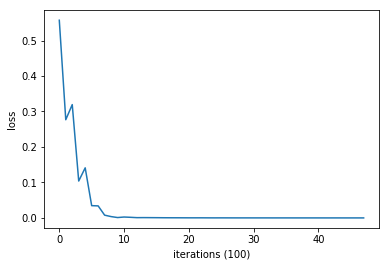

In [42]:
x_axis = np.arange(len(avg_losses))
plt.plot(x_axis, avg_losses, label='train')
plt.xlabel('iterations (100)')
plt.ylabel('loss')
plt.show()

### Test model

In [43]:
n_test = len(test_loader) * batch_size
wrong_predictions = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # See which are error predictions
        result = (predicted == labels)
        err_imgs = images[result == 0] # 0 means wrong prediction
        err_labels = labels[result == 0]
        err_outputs = predicted[result == 0]
        for img, lbl, out in zip(err_imgs, err_labels, err_outputs):
            wrong_predictions.append((img, lbl, out))
     
    print('Test Accuracy of the model on the {} test images: {} %'.format(n_test, 100 * correct / total))

Test Accuracy of the model on the 1100 test images: 81.37614678899082 %


### Test memo:

#### Model 1
|mode/vec|dataset size(train/test)|#epoch|      model  |  optimizer | parameters |lr| accuracy  |
|-----|-----------------------|-------|--------------|------------|------------|--|------------|
|-nonstatic -rand|9572/1100|20|(conv- relu - pool), (linear)x2 |torch.optim.Adam|-|0.01| 77.15%|
|-nonstatic -rand|9572/1100|20|(conv- relu - pool), (linear-relu)x2 |torch.optim.Adam|Kaiming He|0.01| 77.52%|
|-nonstatic -rand|9572/1100|20|(conv- relu - pool), (linear-relu)x2 |torch.optim.Adam|Kaiming He|0.001| 80.27%|
|-nonstatic -word2vec|9572/1100|20|(conv- relu - pool), (linear-relu)x2 |torch.optim.Adam|Kaiming He|0.001| 81.83%|